In [2]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import sys
from src.modules import conf, fit, spec, evl, pred
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline
sns.set(style='ticks')
plt.rcParams['figure.figsize'] = [24, 8]
plt.rcParams['figure.dpi']

100.0

In [5]:
data = fit.load_pcls(
        conf["Athlete"]["name"],
        conf["Athlete"]["activity_type"],
        conf["Paths"]["pcl"],
    )

100%|██████████| 361/361 [00:00<00:00, 742.79it/s] 


In [6]:
from src.heuristics import random_shooting
from src.heuristics import genetic_optimization

In [7]:
r_cross = conf['GO']['r_cross']
r_mut = conf['GO']['r_mut']

In [77]:
train_df, test_df = fit.get_train_test_df(data,ratio=0.7)
test_df, valid_df = fit.get_test_valid_df(test_df)
print(len(train_df),len(test_df),len(valid_df))

182943 103870 6449


In [9]:
_,_,rmse,cols = random_shooting.random_shoot(
                          train_df=train_df,
                          test_df=test_df,
                          hmax=30,
                          endog='enhanced_speed',
                          )

100%|██████████| 30/30 [00:34<00:00,  1.15s/it]


In [11]:
sorted_cols = [x for _, x in sorted(zip(rmse, cols))]
best, best_eval = genetic_optimization.genetic_algorithm(10, r_cross,r_mut ,sorted_cols,train_df,test_df,train_df.columns,'enhanced_speed')

 30%|███       | 3/10 [01:50<04:24, 37.79s/it]

New best: 1.655126760671474


 80%|████████  | 8/10 [05:12<01:19, 39.95s/it]

New best: 1.6444188310479428


100%|██████████| 10/10 [06:36<00:00, 39.60s/it]

New best: 1.6444073626078157


In [78]:
form = random_shooting.get_form(list(best),endog='enhanced_speed')
# form = random_shooting.get_form(list(cols[rmse.index(np.min(rmse))]), endog='enhanced_speed')
# form = random_shooting.get_form(list(train_df.columns),endog='enhanced_speed')
# form = 'enhanced_speed ~ heart_rate + distance + enhanced_altitude + cadence + temp + wind_speed + wind_direct + rain + dist_diff + cadence_delayed + enhanced_altitude_delayed + slope_ascent + slope_descent + slope_steep -1'
result = spec.ols_form(train_df, form)
pred_ols = pred.predict(valid_df, result)
evl.rmse(valid_df.enhanced_speed,pred_ols)

2.132071448964702

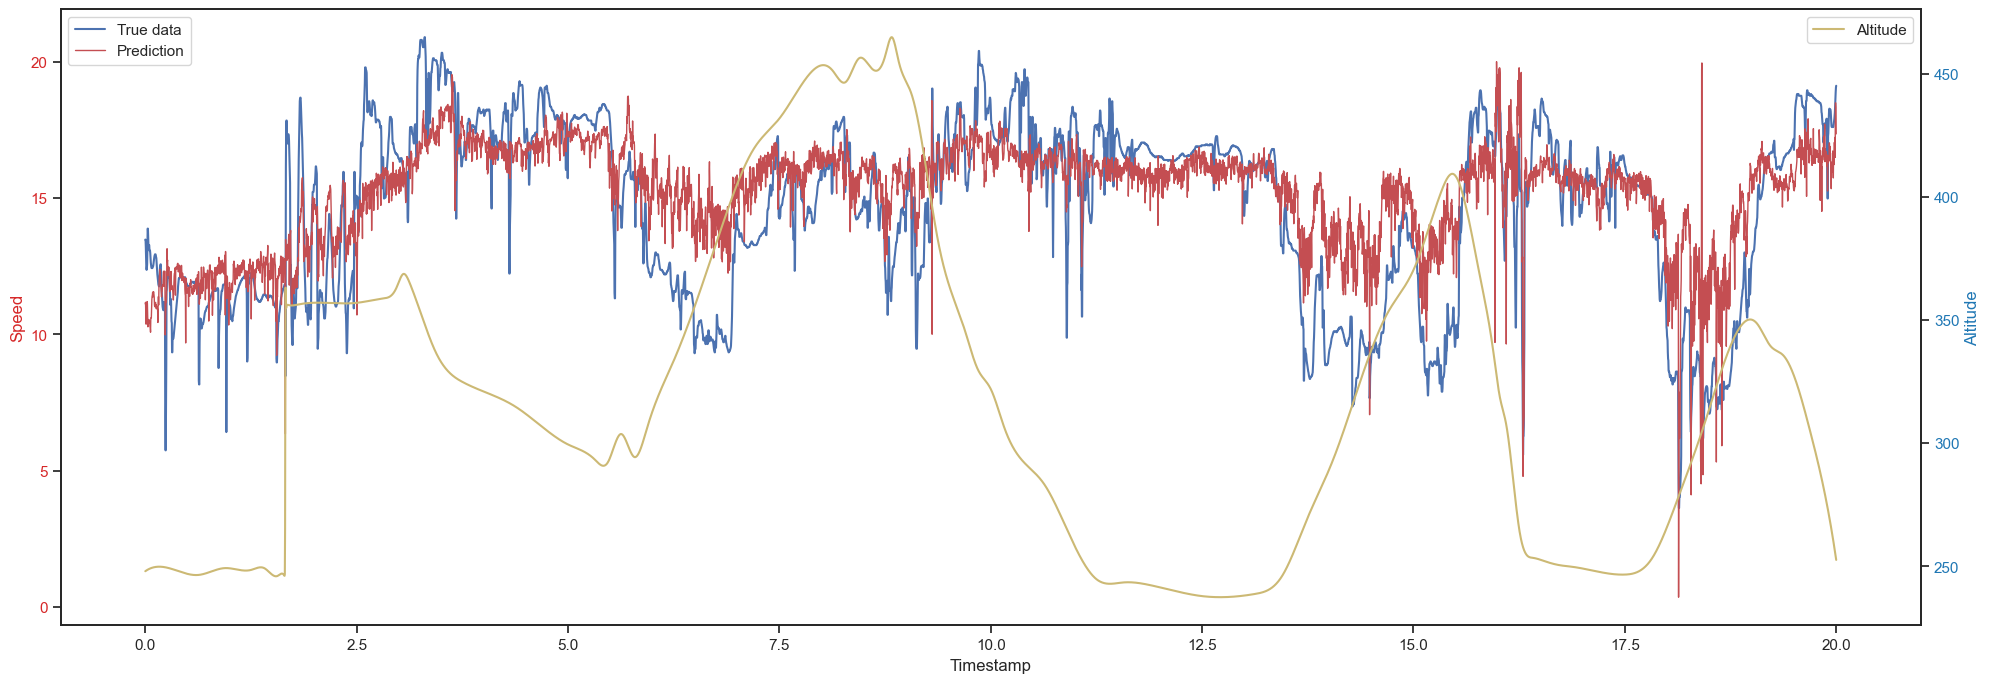

In [79]:
fig = evl.plot(df=valid_df,pred=pred_ols,endog='enhanced_speed')